<a href="https://colab.research.google.com/github/bhavesheccentr1c/Cyberbullying-Detection-in-HINDI-ENG-Text/blob/main/CyberBullying_CNN_BiLSTM_Model(96_10_acc)__augmentation_before_train_val_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries (if not already available)
!pip install tensorflow numpy pandas scikit-learn matplotlib seaborn nltk
!pip install indic-nlp-library

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
import re
import io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
train_data = pd.read_csv('https://drive.google.com/uc?id=1ETMhg4ZGZOaSAWjKAcvNAogKdvK0eiZD')

In [ ]:
df_swear_words  = pd.read_csv('https://drive.google.com/uc?id=1C5f_piOJAIncOUujrOufDSsujmbSY388', header=None)

# Extract Romanized & Hindi swear words
swear_words_romanized = df_swear_words.iloc[0].dropna().str.lower().tolist()
swear_words_hindi = df_swear_words.iloc[1].dropna().str.lower().tolist()

# Combine both sets
all_swear_words = list(set(swear_words_romanized + swear_words_hindi))

# Create DataFrame without "ID"
swear_df = pd.DataFrame({
    "Text": all_swear_words,
    "Sub-task A": "OAG",
    "Sub-task B": "NGEN"  # Change to "NGEN" if needed
})

# Append to train_data
train_data = pd.concat([train_data.drop(columns=["ID"], errors="ignore"), swear_df], ignore_index=True)

# Shuffle dataset
train_data = shuffle(train_data, random_state=42).reset_index(drop=True)

# Save updated dataset
train_data.to_csv("updated_dataset.csv", index=False)
print("\nDataset successfully saved as updated_dataset.csv")
train_data.head()


Dataset successfully saved as updated_dataset.csv


,Text,Sub-task A,Sub-task B
0,Sab actors chutiya hain ye aam aadmi wo log Ko...,CAG,NGEN
1,@Madhusmita Pradhan yaar try to understand.......,NAG,NGEN
2,Are Bhai Bhai Bhai Bhai Bhai Bhai 😃😃😃😃😃😃 log k...,NAG,NGEN
3,@Vijay Sharma sahi kaha,NAG,NGEN
4,Is laude ko kis ne review karne diya vai.. gan...,OAG,GEN


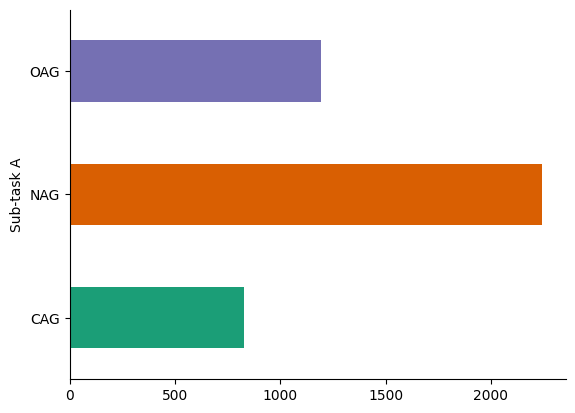

In [ ]:
# @title Sub-task A

from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('Sub-task A').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
!pip install nlpaug
import nlpaug.augmenter.word as naw
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

# ... (your existing code: HindiTextPreprocessor, etc.) ...
def list_to_string(text):
    if isinstance(text, list):
        return ' '.join(text)
    else:
        return text

def is_devanagari(text):
    """Check if text contains Devanagari script."""
    devanagari_pattern = re.compile(r'[\u0900-\u097F]')
    return bool(devanagari_pattern.search(text))

# 1. Define augmentation function (same as before)
def augment_text(text, augs, num_aug):
    """Augments a text using multiple augmenters."""
    augmented_texts = [text]  # Start with the original text

    # Check if text contains Hindi script
    if is_devanagari(text):
        return augmented_texts  # Return original text without augmentations

    for _ in range(num_aug):
        for aug in augs:
            try:  # Wrap in a try-except block
                augmented_text = aug.augment(text)
                augmented_texts.append(augmented_text)
            except NotImplementedError:

                pass
    return augmented_texts

# 2. Initialize augmenters (same as before)
aug_synonym = naw.SynonymAug(aug_src='wordnet')
aug_insert = naw.RandomWordAug(action="insert", aug_p=0.1)  # Check if this works
aug_delete = naw.RandomWordAug(action="delete", aug_p=0.1)  # Check if this works

# 3. Create a list of augmenters (same as before)
augmentors = [aug_synonym, aug_insert, aug_delete]

# 4. Apply augmentation to each class
all_classes = train_data['Sub-task A'].unique()  # Get all unique classes

# Define the desired number of augmentations for each class (adjust as needed)
num_aug_per_class = {
    "OAG": 2,
    "CAG": 3,
    "NAG": 1
}

print(" Classes:", all_classes)


augmented_data = []
for class_label in all_classes:
    class_indices = train_data[train_data['Sub-task A'] == class_label].index
    num_aug = num_aug_per_class.get(class_label, 1)  # Default to 1 augmentation if not specified

    for index in class_indices:
        text = train_data.loc[index, 'Text']

        augmented_texts = augment_text(text, augmentors, num_aug=num_aug)
        for aug_text in augmented_texts[1:]:  # Skip original text
            augmented_data.append({
                'Text': aug_text,
                'Sub-task A': class_label,
                'Sub-task B': train_data.loc[index, 'Sub-task B']
            })


# 5. Concatenate augmented data (same as before)
augmented_df = pd.DataFrame(augmented_data)
augmented_df['Text'] = augmented_df['Text'].apply(list_to_string)
augmented_df.to_csv("augemented_dataset.csv", index=False)

def list_to_string(text):
    if isinstance(text, list):
        return ' '.join(text)
    else:
        return text

train_data['Text'] = train_data['Text'].apply(list_to_string)
augmented_df['Text'] = augmented_df['Text'].apply(list_to_string)
print("\n Augmented Dataset successfully saved as augemented_dataset.csv")
train_data = pd.concat([train_data, augmented_df], ignore_index=True)
train_data.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.7 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


 Classes: ['CAG' 'NAG' 'OAG']

 Augmented Dataset successfully saved as augemented_dataset.csv


,Text,Sub-task A,Sub-task B
0,Sab actors chutiya hain ye aam aadmi wo log Ko...,CAG,NGEN
1,@Madhusmita Pradhan yaar try to understand.......,NAG,NGEN
2,Are Bhai Bhai Bhai Bhai Bhai Bhai 😃😃😃😃😃😃 log k...,NAG,NGEN
3,@Vijay Sharma sahi kaha,NAG,NGEN
4,Is laude ko kis ne review karne diya vai.. gan...,OAG,GEN


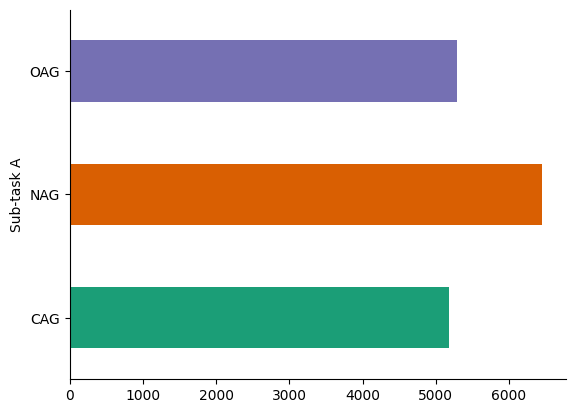

In [ ]:
# @title Sub-task A

from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('Sub-task A').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Shuffle dataset
train_data = shuffle(train_data, random_state=42).reset_index(drop=True)

train_data.to_csv("updated_dataset.csv", index=False)
print("\nDataset successfully saved as updated_dataset.csv")


Dataset successfully saved as updated_dataset.csv


In [ ]:
import re
import string
import unicodedata
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import emoji
import base64
import json

# Download required NLTK data packages
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    pass

class HindiTextPreprocessor:
    """
    A preprocessor for Hindi text that handles both Devanagari script and romanized Hindi.
    Designed for cyberbullying detection with slang expansion capabilities.
    """

    def __init__(self):
        """Initialize stopwords, slang mappings, and spelling variants."""

        # Load Hindi stopwords from NLTK
        try:
            self.hindi_stopwords = set(stopwords.words('hindi'))
        except:
            self.hindi_stopwords = set()

        # Load English stopwords from NLTK
        try:
            self.english_stopwords = set(stopwords.words('english'))
        except:
            self.english_stopwords = set()

        # Common romanized Hindi stopwords (function words with little semantic value)
        self.romanized_stopwords = {
            'main', 'hai', 'ho', 'ki', 'kya', 'hum', 'tha', 'thi', 'se', 'ko', 'par',
            'me', 'mein', 'ka', 'ke', 'ki', 'hai', 'the', 'ye', 'aur', 'ya', 'ek',
            'pe', 'to', 'bhi', 'kuch', 'na', 'ne', 'jo', 'ab', 'hain', 'yeh', 'hi'
        }

        # Combine all stopword sets
        self.all_stopwords = self.hindi_stopwords.union(
            self.english_stopwords
        ).union(self.romanized_stopwords)

        # Load slang/abuse word mappings from encoded string
        self.slang_dict = self._load_encoded_mappings()

        # Define common spelling variations for romanized Hindi words
        # Key: standard form, Value: list of variations
        self.romanized_variants = {
            'hai': ['he', 'hey', 'h'],
            'kya': ['kia', 'kea', 'kiya'],
            'nahi': ['nai', 'nahin', 'nhi', 'ni'],
            'bohot': ['bahut', 'bhot', 'boht'],
            'acha': ['accha', 'achchha', 'acchha'],
            'mujhe': ['muje', 'mujhey'],
            'tum': ['toom', 'tm'],
            'aapko': ['aapko', 'apko'],
        }

        # Create reverse mapping: variant -> standard form
        self.standardize_map = {}
        for standard, variants in self.romanized_variants.items():
            for variant in variants:
                self.standardize_map[variant] = standard

    def _load_encoded_mappings(self):
        """
        Decode base64 encoded slang/abuse word mappings.
        This keeps sensitive words hidden from direct view in the source code.

        Returns:
            dict: Mapping of abbreviations/slang to their full forms
        """
        # Base64 encoded JSON containing slang -> full form mappings
        encoded_data = "eyJhZiI6ICJhcyBmdWNrIiwgImJ0dyI6ICJieSB0aGUgd2F5IiwgImxvbCI6ICJsYXVnaGluZyBvdXQgbG91ZCIsICJsbWFvIjogImxhdWdoaW5nIG15IGFzcyBvZmYiLCAic3RmdSI6ICJzaHV0IHRoZSBmdWNrIHVwIiwgImd0Zm8iOiAiZ2V0IHRoZSBmdWNrIG91dCIsICJmdSI6ICJmdWNrIHlvdSIsICJ3dGYiOiAid2hhdCB0aGUgZnVjayIsICJiYyI6ICJiZWhlbmNob2QiLCAibWMiOiAibWFkZXJjaG9kIiwgImJzZGsiOiAiYmVoZW5jaG9kIiwgImNodXRpeWEiOiAiY2h1dGl5YSJ9"

        try:
            # Decode: base64 -> bytes -> string -> JSON -> dict
            decoded_bytes = base64.b64decode(encoded_data)
            decoded_str = decoded_bytes.decode('utf-8')
            return json.loads(decoded_str)
        except Exception as e:
            print(f"Warning: Could not decode slang mappings. Error: {e}")
            # Fallback to safe mappings if decoding fails
            return {
                'lol': 'laughing out loud',
                'btw': 'by the way',
                'omg': 'oh my god'
            }

    def is_devanagari(self, text):
        """
        Check if text contains any Devanagari script characters.

        Args:
            text (str): Input text

        Returns:
            bool: True if Devanagari characters found, False otherwise
        """
        devanagari_pattern = re.compile(r'[\u0900-\u097F]')
        return bool(devanagari_pattern.search(text))

    def normalize_devanagari(self, text):
        """
        Apply Unicode normalization to Devanagari text.
        NFC (Canonical Decomposition, followed by Canonical Composition)

        Args:
            text (str): Input text in Devanagari

        Returns:
            str: Normalized text
        """
        text = unicodedata.normalize('NFC', text)
        return text

    def preprocess_hindi_script(self, text):
        """
        Preprocess text written in Devanagari script.

        Args:
            text (str): Input text in Devanagari

        Returns:
            str: Preprocessed text with stopwords removed
        """
        # Normalize Unicode characters
        text = self.normalize_devanagari(text)

        # Extract only Devanagari and Latin characters (removes punctuation)
        tokens = re.findall(r'[\u0900-\u097F]+|[a-zA-Z]+', text)

        # Remove Hindi stopwords
        tokens = [t for t in tokens if t not in self.hindi_stopwords]

        return ' '.join(tokens)

    def standardize_romanized(self, text):
        """
        Standardize spelling variations in romanized Hindi.
        Example: 'nai' -> 'nahi', 'kia' -> 'kya'

        Args:
            text (str): Input text with romanized Hindi

        Returns:
            str: Text with standardized spellings
        """
        words = text.split()
        standardized_words = []

        for word in words:
            lower_word = word.lower()
            # Replace variant with standard form if it exists in mapping
            if lower_word in self.standardize_map:
                standardized_words.append(self.standardize_map[lower_word])
            else:
                standardized_words.append(word)

        return ' '.join(standardized_words)

    def expand_slang(self, text):
        """
        Expand slang and abbreviations to their full forms.
        Example: 'lol' -> 'laughing out loud', 'wtf' -> 'what the fuck'

        Args:
            text (str): Input text with slang

        Returns:
            str: Text with expanded slang
        """
        words = text.split()
        expanded_words = []

        for word in words:
            lower_word = word.lower()
            # Expand only if it's slang and not a stopword
            if lower_word in self.slang_dict and lower_word not in self.all_stopwords:
                expanded_words.append(self.slang_dict[lower_word])
            else:
                expanded_words.append(word)

        return ' '.join(expanded_words)

    def preprocess_romanized_hindi(self, text):
        """
        Preprocess romanized Hindi text (Hindi written in Latin script).

        Args:
            text (str): Input romanized Hindi text

        Returns:
            str: Preprocessed text
        """
        # Convert to lowercase for consistency
        text = text.lower()

        # Normalize Unicode (handles mixed characters)
        text = unicodedata.normalize('NFKC', text)

        # Standardize spelling variations (nai -> nahi)
        text = self.standardize_romanized(text)

        # Expand slang and abbreviations (wtf -> what the fuck)
        text = self.expand_slang(text)

        # Tokenize using NLTK or fallback to simple split
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()

        # Filter tokens: remove stopwords, punctuation, numbers, empty strings
        tokens = [t for t in tokens
                  if t not in self.all_stopwords          # Not a stopword
                  and t not in string.punctuation         # Not punctuation
                  and t.strip()                           # Not empty
                  and not t.isdigit()]                    # Not a number

        return ' '.join(tokens)

    def remove_emojis(self, text):
        """
        Remove all emoji characters from text.

        Args:
            text (str): Input text with emojis

        Returns:
            str: Text without emojis
        """
        try:
            return emoji.replace_emoji(text, replace='')
        except:
            return text

    def remove_urls(self, text):
        """
        Remove URLs (http/https/www) from text.

        Args:
            text (str): Input text with URLs

        Returns:
            str: Text without URLs
        """
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub('', text)

    def remove_user_mentions(self, text):
        """
        Remove user mentions/handles (e.g., @username) from text.

        Args:
            text (str): Input text with mentions

        Returns:
            str: Text without mentions
        """
        mention_pattern = re.compile(r'@\S+')
        return mention_pattern.sub('', text)

    def remove_hashtags(self, text):
        """
        Remove hashtags (e.g., #trending) from text.

        Args:
            text (str): Input text with hashtags

        Returns:
            str: Text without hashtags
        """
        hashtag_pattern = re.compile(r'#\S+')
        return hashtag_pattern.sub('', text)

    def remove_extra_whitespace(self, text):
        """
        Replace multiple spaces with single space and trim.

        Args:
            text (str): Input text with extra whitespace

        Returns:
            str: Text with normalized whitespace
        """
        return re.sub(r'\s+', ' ', text).strip()

    def preprocess(self, text):
        """
        Main preprocessing pipeline. Handles both Devanagari and romanized Hindi.

        Steps:
        1. Handle null/empty values
        2. Remove URLs, mentions, hashtags, emojis
        3. Detect script type (Devanagari vs romanized)
        4. Apply appropriate preprocessing
        5. Clean up whitespace

        Args:
            text (str): Input text to preprocess

        Returns:
            str: Fully preprocessed text
        """
        # Handle null or empty values
        if not text or pd.isna(text):
            return ""

        # Ensure text is string type
        text = str(text)

        # Remove noise
        text = self.remove_urls(text)
        text = self.remove_user_mentions(text)
        text = self.remove_hashtags(text)
        text = self.remove_emojis(text)

        # Choose preprocessing method based on script
        if self.is_devanagari(text):
            text = self.preprocess_hindi_script(text)
        else:
            text = self.preprocess_romanized_hindi(text)

        # Final whitespace cleanup
        text = self.remove_extra_whitespace(text)
        return text


def encode_slang_dict(slang_dict):
    """
    Helper function to encode a slang dictionary to base64.
    Use this to create encoded strings for your own slang mappings.

    Args:
        slang_dict (dict): Dictionary mapping slang -> full form

    Returns:
        str: Base64 encoded string

    Example:
        >>> my_slang = {"lol": "laughing out loud", "bc": "behenchod"}
        >>> encoded = encode_slang_dict(my_slang)
        >>> print(encoded)
    """
    json_str = json.dumps(slang_dict)
    encoded = base64.b64encode(json_str.encode('utf-8'))
    return encoded.decode('utf-8')

    # Initialize preprocessor
    preprocessor = HindiTextPreprocessor()

    # Sample texts for demonstration
    sample_texts = [
        "यह एक अच्छा उदाहरण है",                                    # Hindi Devanagari script
        "ye ek acha example hai",                                     # Romanized Hindi
        "Check out https://example.com @user #trending lol 😊",      # With noise (URL, mention, hashtag, emoji)
        "mujhe yeh bohot pasand hai btw",                            # With spelling variants and slang
        "wtf this is bc crazy 123",                                  # With slang and numbers
    ]

    print("Preprocessing Examples:")
    print("-" * 50)
    for text in sample_texts:
        preprocessed = preprocessor.preprocess(text)
        print(f"Original:     {text}")
        print(f"preprocessed_text: {preprocessed}")
        print()

train_data['preprocessed_text'] = train_data['Text'].apply(preprocessor.preprocess)

In [ ]:
# Label encoding for Sub-task A (Cyberbullying Labels: OAG, NAG)
label_encoder_A = LabelEncoder()
train_data['Sub-task A Label'] = label_encoder_A.fit_transform(train_data['Sub-task A'])

# Label encoding for Sub-task B (Gender Labels: GEN, NGEN)
label_encoder_B = LabelEncoder()
train_data['Sub-task B Label'] = label_encoder_B.fit_transform(train_data['Sub-task B'])

# Display the label encodings
print(label_encoder_A.classes_)  # Output: ['NAG', 'OAG']
print(label_encoder_B.classes_)  # Output: ['NGEN', 'GEN']



['CAG' 'NAG' 'OAG']
['GEN' 'NGEN']


In [ ]:
# Features (X) and Labels (y1 and y2)
X = train_data['preprocessed_text'].values
y1 = train_data['Sub-task A Label'].values  # Cyberbullying labels (OAG, NAG)
y2 = train_data['Sub-task B Label'].values  # Gender labels (GEN, NGEN)


In [ ]:
# Split into training and validation sets
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

# Verify the split
print(len(X_train), len(X_val))

13538 3385


In [ ]:
# Set the maximum number of words in the vocabulary and the maximum sequence length
max_words = 10000  # Vocabulary size (top most frequent words)
max_len = 100  # Maximum sequence length (pad all sequences to this length)

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# Check the shape of the padded sequences
print(X_train_pad.shape, X_val_pad.shape)


(13538, 100) (3385, 100)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_A = compute_class_weight('balanced', classes=np.unique(y1_train), y=y1_train)
class_weights_A = dict(enumerate(class_weights_A))
# Calculate class weights AFTER data augmentation for Sub-task B
class_weights_B = compute_class_weight('balanced', classes=np.unique(y2_train), y=y2_train)
class_weights_B = dict(enumerate(class_weights_B))


print("Class_wieghts_B" ,class_weights_B)
print("Class_wieghts_A" ,class_weights_A)

Class_wieghts_B {0: np.float64(2.6226268888027895), 1: np.float64(0.617778589029844)}
Class_wieghts_A {0: np.float64(1.093979797979798), 1: np.float64(0.8742089629342632), 2: np.float64(1.0615541441229515)}


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.losses import Loss , binary_crossentropy

# Register the custom loss function
@register_keras_serializable()
# Custom weighted loss function for Sub-task B (binary_crossentropy)
def weighted_binary_crossentropy(pos_weight):
    def loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) * pos_weight
    return loss

# Define the model
input_layer = Input(shape=(max_len,))

# Embedding Layer
embedding_layer = Embedding(input_dim=max_words, output_dim=100, input_length=max_len)(input_layer)

# CNN Layer
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
maxpool_layer = MaxPooling1D(pool_size=4)(conv_layer)

# BiLSTM Layer
bi_lstm_layer = Bidirectional(LSTM(units=64, return_sequences=False))(maxpool_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)

# Fully connected layer
dense_layer = Dense(32, activation='relu')(dropout_layer)
dropout_layer_2 = Dropout(0.5)(dense_layer)

# Output layers (with valid names)
output_1 = Dense(len(np.unique(y1)), activation='softmax', name='sub_task_A')(dropout_layer_2)  # Cyberbullying classification (Binary: OAG vs NAG)
output_2 = Dense(1, activation='sigmoid', name='sub_task_B')(dropout_layer_2)  # Gender classification (GEN vs NGEN)

# Define the model
model = Model(inputs=input_layer, outputs=[output_1, output_2])

# Compile the model with appropriate loss functions for multi-task learning
model.compile(optimizer=Adam(),
              loss={'sub_task_A': 'sparse_categorical_crossentropy', 'sub_task_B': weighted_binary_crossentropy(class_weights_B[0])},
              metrics={'sub_task_A': 'accuracy', 'sub_task_B': 'accuracy'},
              run_eagerly=True)

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      1,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 96, 128)        │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 24, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         98,816 │ max_pooling1d[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          4,128 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sub_task_A (Dense)        │ (None, 3)              │             99 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sub_task_B (Dense)        │ (None, 1)              │             33 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,167,204 (4.45 MB)

 Trainable params: 1,167,204 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 2.2850 - sub_task_A_accuracy: 0.4374 - sub_task_A_loss: 1.0498 - sub_task_B_accuracy: 0.8208 - sub_task_B_loss: 1.2352
Epoch 1: val_loss improved from inf to 0.88688, saving model to best_model_1.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 245s 576ms/step - loss: 2.2839 - sub_task_A_accuracy: 0.4377 - sub_task_A_loss: 1.0495 - sub_task_B_accuracy: 0.8209 - sub_task_B_loss: 1.2345 - val_loss: 0.8869 - val_sub_task_A_accuracy: 0.7935 - val_sub_task_A_loss: 0.5473 - val_sub_task_B_accuracy: 0.9548 - val_sub_task_B_loss: 0.3395
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 0.8189 - sub_task_A_accuracy: 0.8061 - sub_task_A_loss: 0.5263 - sub_task_B_accuracy: 0.9700 - sub_task_B_loss: 0.2926
Epoch 2: val_loss improved from 0.88688 to 0.54671, saving model to best_model_1.keras
424/424 ━━━━━━━━━━━━━━━━━━━━ 263s 579ms/step - loss: 0.8186 - sub_task_A_accuracy: 0.8062 - sub_task_A_loss: 0.5261 - sub_task_B_accuracy: 0.9700 - s

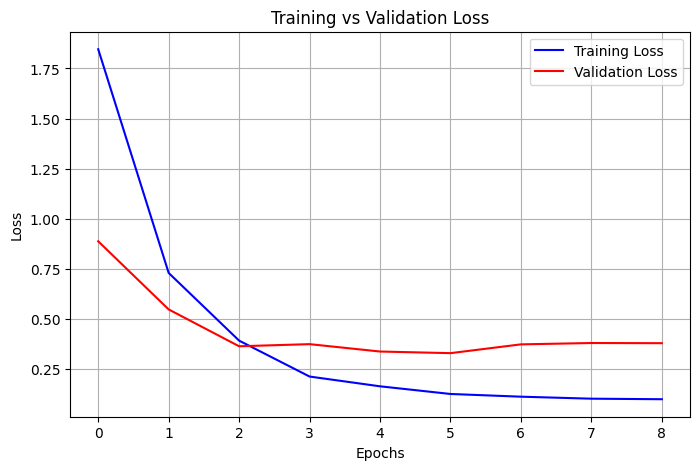

In [ ]:
# Save Best Model
model_checkpoint = ModelCheckpoint("best_model_1.keras", monitor='val_loss', save_best_only=True, verbose=1)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

# Train the model
history = model.fit(X_train_pad,
                    {'sub_task_A': y1_train, 'sub_task_B': y2_train},
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_pad, {'sub_task_A': y1_val, 'sub_task_B': y2_val}),
                    callbacks=[early_stopping, model_checkpoint])

# ==============================
# 📈 PLOT TRAINING & VALIDATION LOSS
# ==============================
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Evaluate the model on the validation set
val_loss, val_sub_task_a_loss, val_sub_task_b_loss, val_sub_task_a_acc, val_sub_task_b_acc = model.evaluate(
    X_val_pad, {'sub_task_A': y1_val, 'sub_task_B': y2_val})

# Print the evaluation results
print(f"Validation Total Loss: {val_loss:.4f}")
print(f"Validation Sub-task A Loss (Cyberbullying): {val_sub_task_a_loss:.4f}")
print(f"Validation Sub-task B Loss (Gender): {val_sub_task_b_loss:.4f}")
print(f"Validation Sub-task A Accuracy (Cyberbullying): {val_sub_task_a_acc:.4f}")
print(f"Validation Sub-task B Accuracy (Gender): {val_sub_task_b_acc:.4f}")



106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.9865 - sub_task_A_accuracy: 0.3942 - sub_task_A_loss: 1.1654 - sub_task_B_accuracy: 0.7846 - sub_task_B_loss: 1.8212
Validation Total Loss: 2.9554
Validation Sub-task A Loss (Cyberbullying): 1.1611
Validation Sub-task B Loss (Gender): 1.7953
Validation Sub-task A Accuracy (Cyberbullying): 0.3950
Validation Sub-task B Accuracy (Gender): 0.7905


In [ ]:
# Predict on validation/test data
predictions = model.predict(X_val_pad)

# For Sub-task A (Cyberbullying - Multi-Class)
y1_pred_proba = predictions[0]  # Assuming the first output is for Sub-task A
y1_pred_class = np.argmax(y1_pred_proba, axis=1)  # Convert to class labels

# For Sub-task B (Gender - Binary)
y2_pred_proba = predictions[1]  # Assuming the second output is for Sub-task B
y2_pred_class = (y2_pred_proba > 0.5).astype(int)  # Threshold for binary classification (0.5)


106/106 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step


In [ ]:
# True labels from your validation data
y1_true = y1_val  # True labels for Cyberbullying (Sub-task A)
y2_true = y2_val  # True labels for Gender (Sub-task B)



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# For Cyberbullying (Sub-task A - Multi-class)
precision_A, recall_A, f1_A, _ = precision_recall_fscore_support(y1_true, y1_pred_class, average='weighted')

# For Gender (Sub-task B - Binary)
precision_B, recall_B, f1_B, _ = precision_recall_fscore_support(y2_true, y2_pred_class, average='binary')

# Print the results
print(f"Sub-task A (Cyberbullying) Precision (Weighted): {precision_A:.4f}")
print(f"Sub-task A (Cyberbullying) Recall (Weighted): {recall_A:.4f}")
print(f"Sub-task A (Cyberbullying) F1-Score (Weighted): {f1_A:.4f}")

print(f"Sub-task B (Gender) Precision (Binary): {precision_B:.4f}")
print(f"Sub-task B (Gender) Recall (Binary): {recall_B:.4f}")
print(f"Sub-task B (Gender) F1-Score (Binary): {f1_B:.4f}")

# Alternatively, print classification reports
print("\nClassification Report for Cyberbullying (Sub-task A):")
print(classification_report(y1_true, y1_pred_class))

print("\nClassification Report for Gender (Sub-task B):")
print(classification_report(y2_true, y2_pred_class))


Sub-task A (Cyberbullying) Precision (Weighted): 0.9614
Sub-task A (Cyberbullying) Recall (Weighted): 0.9610
Sub-task A (Cyberbullying) F1-Score (Weighted): 0.9610
Sub-task B (Gender) Precision (Binary): 0.9886
Sub-task B (Gender) Recall (Binary): 0.9953
Sub-task B (Gender) F1-Score (Binary): 0.9919

Classification Report for Cyberbullying (Sub-task A):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1040
           1       0.97      0.94      0.96      1306
           2       0.94      0.98      0.96      1039

    accuracy                           0.96      3385
   macro avg       0.96      0.96      0.96      3385
weighted avg       0.96      0.96      0.96      3385


Classification Report for Gender (Sub-task B):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       606
           1       0.99      1.00      0.99      2779

    accuracy                           0.99      33

In [ ]:
def predict_cyberbullying_and_gender(text, model, tokenizer, max_len):
    """
    Predicts the cyberbullying and gender labels for a given text.

    Args:
        text (str): The input text to be classified.
        model: The trained Keras model.
        tokenizer: The tokenizer used to preprocess the text.
        max_len (int): The maximum sequence length.

    Returns:
        tuple: A tuple containing the predicted cyberbullying label and gender label.
    """
    # Preprocess the input text
    preprocessed_text = preprocessor.preprocess(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Make predictions
    predictions = model.predict(padded_sequence)

    # Get predicted labels
    cyberbullying_label = np.argmax(predictions[0])  # Sub-task A
    gender_label = (predictions[1] > 0.5).astype(int)[0][0]  # Sub-task B

    # Map label indices back to original labels (if needed)
    cyberbullying_label = label_encoder_A.inverse_transform([cyberbullying_label])[0]
    gender_label = label_encoder_B.inverse_transform([gender_label])[0]

    return cyberbullying_label, gender_label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import re
from indicnlp.tokenize import indic_tokenize


# Load keywords from file
def load_keywords(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

keywords_oag = load_keywords("/content/drive/MyDrive/Cyberbullying detection model/HINDI DATASET/keywords_oag.txt")
hindi_keywords = load_keywords("/content/drive/MyDrive/Cyberbullying detection model/HINDI DATASET/hindi_keywords.txt")

def identify_oag_combined(text):
    """
    Identifies text as 'OAG' if it contains any abusive keywords
    in Romanized or Hindi script.
    """
    text_lower = text.lower()

    # 1. Check Romanized keywords
    for keyword in keywords_oag:
        if keyword in text_lower:
            return "OAG"

    # 2. Check Hindi keywords
    tokens = indic_tokenize.trivial_tokenize(text)
    for keyword in hindi_keywords:
        if keyword in tokens:
            return "OAG"

    return None


In [ ]:
model = tf.keras.models.load_model('/content/best_Cyberbullying_model.keras', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy, 'loss': weighted_binary_crossentropy(class_weights_B[0])})


In [ ]:
# Get input text from the user
input_text = input("Enter the text: ")

# Apply the function directly to the input text
identified_label = identify_oag_combined(input_text)
cyberbullying_label, gender_label = predict_cyberbullying_and_gender(input_text, model, tokenizer, max_len)

if identified_label:  # Check if rule-based label is not empty
    print(f"Cyberbullying Label: {identified_label}")
elif cyberbullying_label != 'NAG': # Prioritize cyberbullying_label if it's not 'NAG'
    print(f"Cyberbullying Label: {cyberbullying_label}")
else:
    print(f"Cyberbullying Label: {cyberbullying_label}")  # Use model prediction if rule-based is empty

print(f"Gender Label: {gender_label}")

KeyboardInterrupt: Interrupted by user

In [ ]:
import json

# Save tokenizer in JSON format
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)


In [ ]:
# Load your Keras model
model = tf.keras.models.load_model('best_model_1.keras', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy, 'loss': weighted_binary_crossentropy(class_weights_B[0])})
# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable resource variables and select TF ops
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('cyberbullying_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1j70g60_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_layer_1')
Output Type:
  List[TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  140180439758416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180372890512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180372889360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440233552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440228368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440230480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440232784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440230672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180440233360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140180303662928: TensorSpec